In [1]:
import os
import re
import glob
import nltk
import numpy as np
import pandas as pd
import pandas_access as mdb
import zipfile
import recordlinkage as rl
from os.path import join, basename
from meza import io
from params import get_params
from nltk.tokenize import word_tokenize
import seaborn as sns
sns.set_context('paper')

pd.set_option("display.max_columns", 150)

Access to database

In [2]:
## Access Birth 2020
params = get_params()
path = '/Users/pierredelice/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/Dgis/Data/nacimiento/'
file = glob.glob(join(path,r'*.csv'))
file_zip = glob.glob(join(path,r'*.zip'))
nacimiento_2020 = 'nac_unzip/Nacimientos_cierre_2020/Nacimientos_cierre_2020.csv'


#Select columns 
cols = ['FOLIO','NOMBRE','PRIMERAPELLIDO',
    'SEGUNDOAPELLIDO','CURPMADRE',
    'FECHANACIMIENTOMADRE','ENTIDADNACIMIENTO',
    'MUNICIPIONACIMIENTO','ENTIDADRESIDENCIA',
    'MUNICIPIORESIDENCIA','LOCALIDADRESIDENCIA',
    'HIJOSNACIDOSMUERTOS','HIJOSNACIDOSVIVOS',
    'AFILIACION','FECHANACIMIENTO',
    'HORANACIMIENTO','SEXO',
    'ENTIDADFEDERATIVAPARTO','MUNICIPIOPARTO',
    'LOCALIDADPARTO','CODIGOPOSTALPARTO']

#Columns to rename
name = {'PRIMERAPELLIDO':'paterno',
'SEGUNDOAPELLIDO':'materno',
'CURPMADRE':'curp',
'FECHANACIMIENTOMADRE':'fech_nac_madre',
'ENTIDADNACIMIENTO':'ent_nac_madre',
'MUNICIPIONACIMIENTO':'mun_nac_madre',
'ENTIDADRESIDENCIA':'ent_res',
'MUNICIPIORESIDENCIA':'mun_res',
'LOCALIDADRESIDENCIA':'local_res',
'HIJOSNACIDOSMUERTOS':'hijos_muertos',
'HIJOSNACIDOSVIVOS':'hijos_vivos',
'FECHANACIMIENTO':'fech_nac',
'ENTIDADFEDERATIVAPARTO':'ent_parto',
'MUNICIPIOPARTO':'mun_parto',
'LOCALIDADPARTO':'localidad_parto'}

#Read data
nac2020 = pd.read_csv(join(path,nacimiento_2020), usecols= cols, low_memory=False)

#Rename columns
nac2020.rename(columns=name, inplace =True)

#To lower case columns
nac2020.columns = [x.lower() for x in nac2020.columns]


#To lower strings columns
nac2020 = nac2020.apply(lambda x: x.astype(str).str.lower())

#Convert to string
#nac2020 = nac2020.convert_dtypes()
nac2020[['ent_nac_madre','mun_nac_madre', \
    'ent_res','mun_res','hijos_muertos', \
    'hijos_vivos', 'afiliacion','sexo', \
    'ent_parto','mun_parto','localidad_parto']] = \
nac2020[['ent_nac_madre','mun_nac_madre', \
    'ent_res','mun_res','hijos_muertos', \
    'hijos_vivos', 'afiliacion','sexo', \
    'ent_parto','mun_parto','localidad_parto']].astype('int16')

nac2020['folio'] = nac2020['folio'].astype('category')
nac2020['fech_nac'] = pd.to_datetime(nac2020['fech_nac'], format='%d/%m/%Y', errors='coerce')
nac2020['fech_nac_madre'] = pd.to_datetime(nac2020['fech_nac_madre'], format='%d/%m/%Y', errors='coerce')
nac2020['horanacimiento'] = pd.to_datetime(nac2020['horanacimiento'], errors='coerce').dt.strftime('%H:%M')

#Edad
nac2020.loc[nac2020.fech_nac_madre == '2089-01-27','fech_nac_madre'] = '1989-01-07'
nac2020.loc[nac2020.fech_nac_madre =='2095-08-30','fech_nac_madre'] = '1995-08-30'
nac2020['edad_madre']=(round((nac2020['fech_nac'] - nac2020['fech_nac_madre'])/np.timedelta64(1, 'Y'),0))
bins = [0,4,9,14,19,24,29,34,39,44,49,
        54,59,64,69,74,79,84,89,94,120]
labels = ['0-4','5-9','10-14','15-19',
        '20-24','25-29','30-34','35-39',
        '40-44','45-49','50-54','54-59',
        '60-64','65-69','70-74','75-79',
        '80-84','85-89','90-94', '95+']
nac2020['agerange'] = pd.cut(nac2020.edad_madre, bins, labels = labels,include_lowest = True)

#Create fullname: Nombre + Apellido materno y paterno
nac2020['name'] = nac2020[['nombre', 'paterno', 'materno']].agg(' '.join, axis=1)

In [3]:
nac2020.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747847 entries, 0 to 1747846
Data columns (total 24 columns):
 #   Column             Dtype         
---  ------             -----         
 0   folio              category      
 1   curp               object        
 2   nombre             object        
 3   paterno            object        
 4   materno            object        
 5   fech_nac_madre     datetime64[ns]
 6   ent_nac_madre      int16         
 7   mun_nac_madre      int16         
 8   ent_res            int16         
 9   mun_res            int16         
 10  local_res          object        
 11  hijos_muertos      int16         
 12  hijos_vivos        int16         
 13  afiliacion         int16         
 14  fech_nac           datetime64[ns]
 15  horanacimiento     object        
 16  sexo               int16         
 17  ent_parto          int16         
 18  mun_parto          int16         
 19  localidad_parto    int16         
 20  codigopostalparto  objec

<AxesSubplot: xlabel='agerange', ylabel='hijos_vivos'>

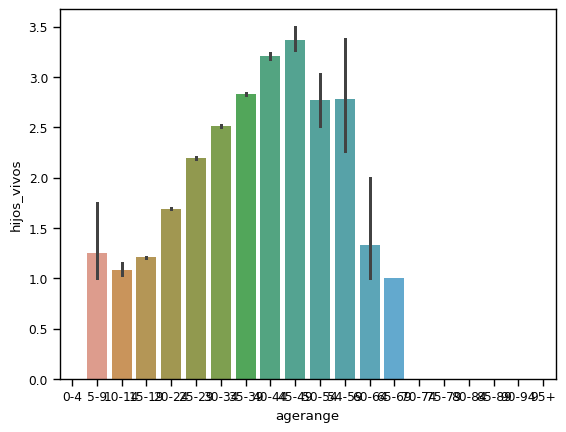

In [4]:
#nac2020.agerange.value_counts().plot(kind='bar')
sns.barplot(
        data=nac2020,
        x="agerange",
        y="hijos_vivos",
        #hue="party",
        #palette=['blue', 'red', 'yellow', 'grey'],
        saturation=0.6,
    )

<AxesSubplot: >

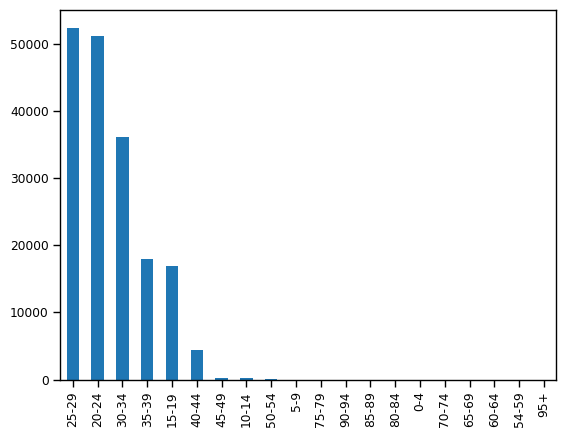

In [5]:
nac2020[nac2020.curp.str.contains('sin informacion')]['agerange'].value_counts().plot(kind='bar')

Entity cleansing

In [6]:
#Selección de los registros a corregir
RE_SUSPICIOUS = re.compile(r'desconocido|se ignora|sin informacion|[&#<>{}\[\]\\]')

def impurity(text, min_len=3):
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len:
        return 0 
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

# add new column to data frame
nac2020['impurity_before'] = nac2020['name'].apply(impurity, min_len=3)

# get the top 3 records
#nac2020[['name', 'impurity_before']].sort_values(by='impurity_before', ascending=False)

In [7]:
len(nac2020[nac2020.impurity_before>0])

2306

In [8]:
def clean(text):
    # convert html escapes like &amp; to characters.
    #text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', '', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', '', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # Unnecessary words and characters
    text = re.sub(r'desconocido|se ignora|sin informacion|informacion|[&#<>{}\[\]\\]','', text)
    return text

nac2020['clean_name'] = nac2020['name'].map(clean)
#nac2020['impurity'] = nac2020['clean_name'].apply(impurity, min_len=3)
#nac2020[['clean_name', 'impurity']].sort_values(by='impurity', ascending=False).head(3)
nac2020[nac2020['clean_name'].apply(impurity, min_len=3) > 0]

,folio,curp,nombre,paterno,materno,fech_nac_madre,ent_nac_madre,mun_nac_madre,ent_res,mun_res,local_res,hijos_muertos,hijos_vivos,afiliacion,fech_nac,horanacimiento,sexo,ent_parto,mun_parto,localidad_parto,codigopostalparto,edad_madre,agerange,name,impurity_before,clean_name


In [9]:
from collections import Counter

counter = Counter()

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter 
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data 
    counter = Counter() 
    
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq') 
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

count_words(nac2020, column='clean_name', preprocess=lambda t: re.findall(r'desconocido|se ignora|sin informacion|[?&#<>{}\[\]\\]*', t))

,freq
token,
,47357809


In [10]:
nac2020[['clean_name','name','nombre','paterno','materno']].isnull().sum()

clean_name    0
name          0
nombre        0
paterno       0
materno       0
dtype: int64

In [11]:
(nac2020[['name','clean_name']].nunique())

name          1657455
clean_name    1657002
dtype: int64

In [12]:
(nac2020[['name','clean_name']].nunique()/len(nac2020))

name          0.948284
clean_name    0.948025
dtype: float64

In [13]:
#(nac2020[['name','clean_name']].nunique()/len(nac2020)).plot(kind='bar')

In [14]:
from recordlinkage.standardise import phonetic


class soundex():
    def soundex_met(nac2020):
        return nac2020.assign(nombre_soundex=phonetic(nac2020['clean_name'],
                                                 method='soundex'))

    def result(nac2020):
        return nac2020.assign(
            id_soundex=nac2020[['nombre_soundex']].agg(''.join, axis=1))
        return id_soundex


nac2020 = soundex.soundex_met(nac2020)
nac2020 = soundex.result(nac2020)

In [15]:
nac = nac2020.sample(n= 100000, random_state=1)

In [16]:
from recordlinkage.index import Block
block_id_soundex = Block(on=['nombre_soundex'])
block_id_s = block_id_soundex.index(nac)
print(f"No of pairs: {len(block_id_s)}")

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2776/2239741818.py:2: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  block_id_soundex = Block(on=['nombre_soundex'])


No of pairs: 18505800


In [17]:
cols = ['folio', 'clean_name','curp', 'fech_nac_madre',
       'ent_nac_madre', 'mun_nac_madre',
       'ent_res',  'mun_res','local_res', 
       'afiliacion','fech_nac', 'horanacimiento',
       'sexo', 'ent_parto',
       'mun_parto', 'localidad_parto']
nac = nac2020[cols]

In [18]:
import time

start_time = time.time()

#Blocking for CANDIDATE PAIRS
Block_id = Block(on=['clean_name', 'fech_nac_madre', 'ent_nac_madre',
'mun_nac_madre', 'curp', 'ent_res','mun_res','horanacimiento'])
Block_id_pairs = Block_id.index(nac)

#pairs = Block_name_pairs.union(Block_id_pairs)
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_2776/2174118127.py:6: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  Block_id = Block(on=['clean_name', 'fech_nac_madre', 'ent_nac_madre',


--- 4.202420949935913 seconds ---


In [19]:
print('Número de duplicados',len(Block_id_pairs))
print('Porcentaje de duplicados',100*len(Block_id_pairs)/len(nac))
Block_id_pairs

Número de duplicados 1087
Porcentaje de duplicados 0.06219079816482793


MultiIndex([( 141030,     249),
            (   2027,    1666),
            (   6967,    6966),
            (  11269,   11268),
            (  13436,   13435),
            (  14030,   14029),
            ( 671075,   16256),
            (  16562,   16534),
            (  17092,   17091),
            (  18631,   18592),
            ...
            (1717351, 1717332),
            (1723586, 1722199),
            (1733848, 1722720),
            (1723071, 1723015),
            (1723041, 1723040),
            (1731535, 1724540),
            (1725197, 1725063),
            (1735970, 1734958),
            (1740127, 1735733),
            (1747671, 1744073)],
           length=1087)

In [20]:
nac0 = nac2020.loc[Block_id_pairs.to_flat_index().str[0]]
nac1 = nac2020.loc[Block_id_pairs.to_flat_index().str[1]]
nac_dup = pd.concat([nac1,nac0])


In [ ]:
nac_dup.sort_values(by = ['clean_name'],axis=0)

In [22]:
#ax = sns.barplot(
#        data=nac_dup,
#        x="ent_res",
#        y="hijos_vivos",
#        #hue="party",
#        #palette=['blue', 'red', 'yellow', 'grey'],
#        saturation=0.6,
#    )

Word embeddings

In [23]:
nac2020.fech_nac_madre = nac2020.fech_nac_madre.astype(str)
nac2020.ent_nac_madre = nac2020.ent_nac_madre.astype(str)
nac2020.mun_nac_madre = nac2020.mun_nac_madre.astype(str)
nac2020.fech_nac = nac2020.fech_nac.astype(str)
id = nac2020[['clean_name','fech_nac_madre','ent_nac_madre', \
    'mun_nac_madre','fech_nac']].agg(' '.join, axis=1)

In [24]:
id = nac2020.clean_name[:100]

In [26]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    #print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in id]

In [ ]:
doc_shingles

In [28]:
import itertools
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

# itertools.combinations finds all (,n) n-pairs
# then we use a map op on the tuples with jaccardSim
pairs = itertools.combinations(id, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
#print(f"**~~~~~~ True similarity scores ~~~~~~**")
#print("Pair\tScore")
#print("-"*14)
#for pair, score in zip(pair_labels, pair_sims):
    #print(f"{pair}\t{score:.3f}")

In [29]:
# Take union of all sets. Convert to an array and assign
# each element an integer based on position in array
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 1533 shingles


In [30]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [31]:
hm = HashManager(shingle_dict)

In [ ]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
#     cols = [sig_mat[:,i] for i in range(sig_mat.shape[1])]
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

# print(f"**~~~~~~ Approximate similarity scores ~~~~~~**")
# print("Pair\t\tApproximate Score\t\tTrue Score")
# print("-"*14)
# for pair, score in sigSimScores(sig_mat):
#     print(f"{pair}\t{score:.3f}")
    
# print(f"**~~~~~~ True similarity scores ~~~~~~**")
# print("Pair\tScore")
# print("-"*14)
# for pair, score in zip(pair_labels, pair_sims):
#     print(f"{pair}\t{score:.3f}")

In [33]:
candidatePairs(true_score_dict, 0.20)

{(1, 50), (5, 18), (13, 75), (33, 42), (33, 45), (39, 88), (41, 91), (66, 73)}

In [ ]:
id.loc[[1,50,5,18,33,45,39,88,41,91,66,73]]

In [ ]:
id.loc[[81,82]]

In [ ]:
nac2020

In [ ]:
nac2020.clean_name.value_counts()

In [ ]:
nac2020.name.value_counts()

<AxesSubplot: >

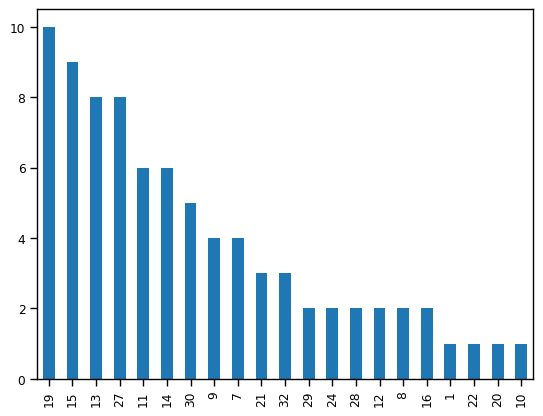

In [51]:
nac2020[nac2020.clean_name.str.contains('maria guadalupe hernandez hernandez')].sort_values(by='fech_nac_madre')['ent_res'].value_counts().plot(kind='bar')

In [40]:
nac2020['clean_name_token'] = nac2020.clean_name.apply(word_tokenize).str.len()

In [ ]:
nac2020[nac2020.clean_name_token ==0]